### analyze dataset from sample with MoS2 + 5nm C60

### analyze C60 part
* for fig4
* adapted from https://github.com/py4dstem/py4DSTEM_tutorials/blob/main/notebooks/version_0.13.7/07_WS2_ACOM_strain.ipynb

Package versions:<br>
python==3.9.15<br>
py4DSTEM==0.13.9<br>
numpy==1.21.6<br>
h5py==3.7.0<br>
matplotlib==3.6.2<br>
pickleshare==0.7.5

In [1]:
%matplotlib widget

In [2]:
import py4DSTEM
import numpy as np
import h5py
import matplotlib.pyplot as plt
import matplotlib as matplotlib
import pickle
from datetime import datetime

In [3]:
data_folder = r'..\data\Figure 4'

data_name = r"\scan_data_scan113x113_gzip.h5"
data_path = data_folder + data_name

In [4]:
file_cif_MoS2 = r'..\data\Figure 4\MoS2.cif'
file_cif_C60 = r'..\data\Figure 4\C60.cif' # cubic fcc

In [5]:
f = h5py.File(data_path, 'r')

In [6]:
# load dataset
dataset = py4DSTEM.io.datastructure.DataCube(data=f['data'])

In [7]:
data_max = 2**12
data_max

4096

In [8]:
#dataset_max = dataset.shape
dataset_shape = dataset.shape
dataset_shape

(113, 113, 512, 512)

In [9]:
# crop dataset for C60 analysis
cx = 259; cy =  247
droi = 80
dataset.crop_Q((cx-droi, cx+droi, cy-droi, cy+droi))

DataCube( A 4-dimensional array of shape (113, 113, 160, 160) called 'datacube',
          with dimensions:

          Rx = [0,1,...] pixels
          Ry = [0,1,...] pixels
          Qx = [0,1,...] pixels
          Qy = [0,1,...] pixels
)

In [10]:
dataset.shape

(113, 113, 160, 160)

In [11]:
# Let's examine the mean diffraction space image - first we compute it:
dataset.get_dp_mean();

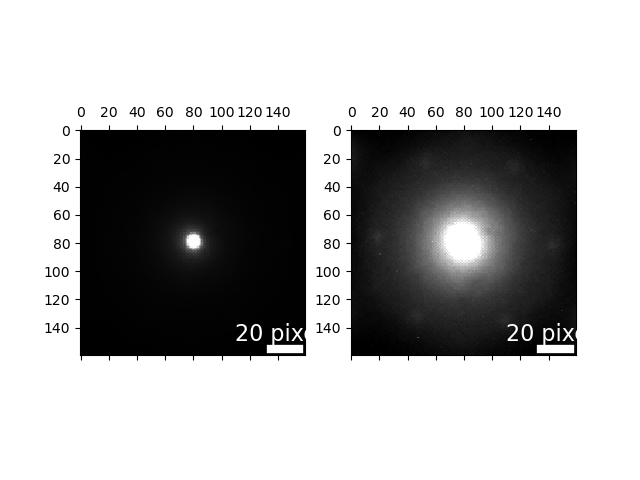

In [12]:
# Plot the mean diffraction pattern
fig,(ax1,ax2) = plt.subplots(1,2)
py4DSTEM.visualize.show(dataset.tree['dp_mean'], scaling = 'none', figsize=(4,4),vmin=0,vmax=data_max, figax=(fig,ax1))
py4DSTEM.visualize.show(dataset.tree['dp_mean'], scaling = 'power', power=0.5, figax=(fig,ax2))

In [13]:
dataset.get_dp_max()

VirtualDiffraction( A 2-dimensional array of shape (160, 160) called 'dp_max',
                    with dimensions:

                    dim0 = [0,1,...] pixels
                    dim1 = [0,1,...] pixels
)

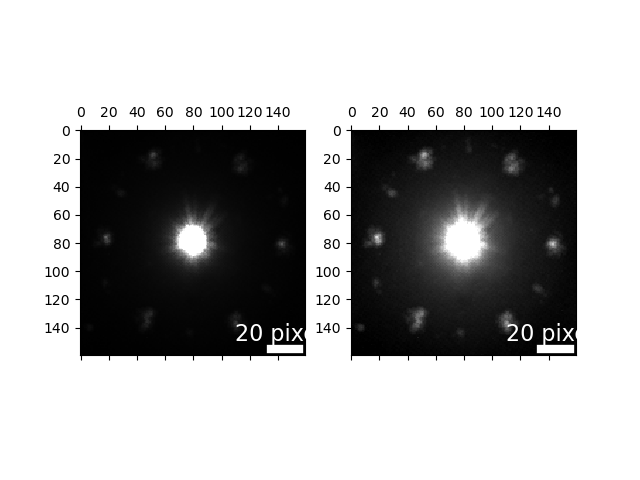

In [14]:
# Plot the max diffraction pattern
fig,(ax1,ax2) = plt.subplots(1,2)
py4DSTEM.visualize.show(dataset.tree['dp_max'], scaling = 'none', figsize=(4,4),vmin=0,vmax=data_max, figax=(fig,ax1))
py4DSTEM.visualize.show(dataset.tree['dp_max'], scaling = 'power', power=0.5, figax=(fig,ax2))

Estimated probe radius = 4.99 pixels


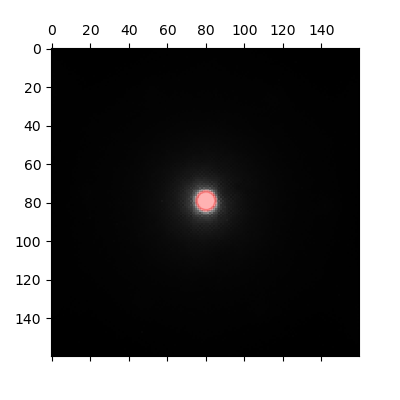

In [15]:
# Estimate the radius of the BF disk, and the center coordinates
probe_semiangle, probe_qx0, probe_qy0 = py4DSTEM.process.calibration.get_probe_size(dataset.tree['dp_mean'].data,
                                                                                    thresh_lower = 0.7, thresh_upper = 1, N = 5)
center = (probe_qx0, probe_qy0)
# plot the mean diffraction pattern, with the estimated probe radius overlaid as a circle
fig, ax = py4DSTEM.visualize.show_circles(dataset.tree['dp_mean'].data,center,probe_semiangle,figsize=(4,4),
                                          returnfig=True,scaling='none',vmin=0,vmax=data_max,)
#ax.set_xlim([100*2, 150*2])
#ax.set_ylim([100*2, 150*2])

# Print the estimate probe radius
print('Estimated probe radius =', '%.2f' % probe_semiangle, 'pixels')

In [16]:
center

(78.87039843694919, 80.0381215708716)

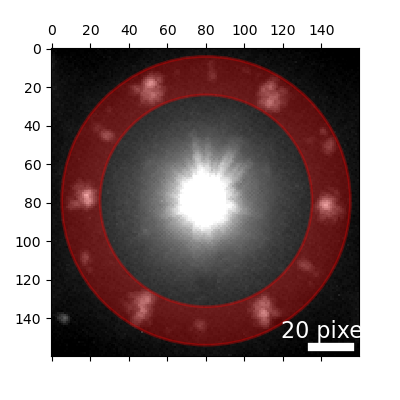

100%|█████████████████████████████████████████████████████████████████████████| 12769/12769 [00:00<00:00, 30791.27it/s]


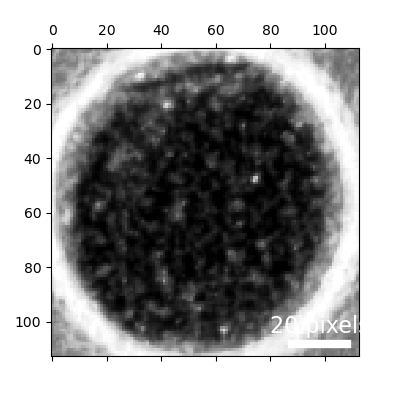

In [17]:
# Create a virtual annular dark field (ADF) image around the first diffraction ring
rmin = 78-23
r_width = 20
radii = (rmin,rmin+r_width)

# Plot the ADF detector
py4DSTEM.visualize.show(dataset.tree['dp_max'], scaling='log', 
                        annulus = {'center':center,'radii':radii,'alpha':0.3,'fill':True}, figsize=(4,4))
# Calculate the ADF image
dataset.get_virtual_image(mode = 'annulus',geometry = (center,radii),name = 'dark_field',)

# Plot the ADF image
py4DSTEM.visualize.show(dataset.tree['dark_field'],figsize=(4,4))

In [18]:
# Because the diffracted signal is so weak, we will just average a subset of the probe positions.
rd = 10
rx_min, rx_max = int(dataset_shape[0]/2) - rd,  int(dataset_shape[0]/2) + rd
ry_min, ry_max = rx_min, rx_max

probe_init = py4DSTEM.process.probe.get_probe_from_4Dscan_ROI_lims(dataset,ROI=(rx_min, rx_max, ry_min, ry_max),
                                                                   align=False,mask_threshold=0.7,mask_expansion=10,
                                                                   mask_opening=3,)

100%|█████████████████████████████████████████████████████████████████████████████| 399/399 [00:00<00:00, 19950.97it/s]


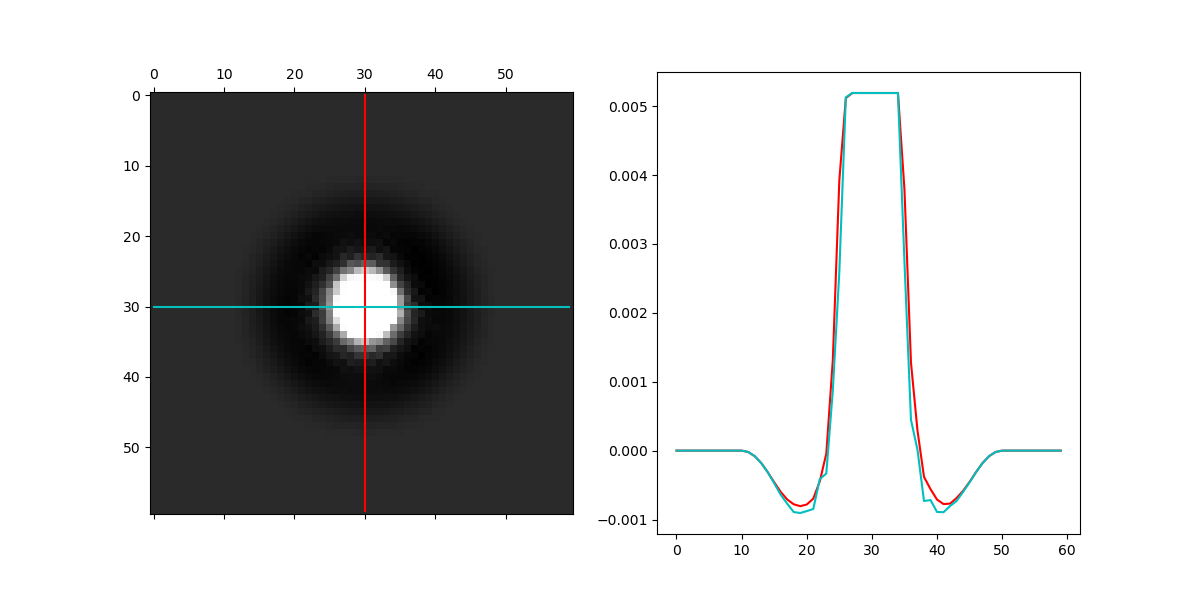

In [19]:
# Subtract a normalization function to give the probe a mean value of zero 
probe_kernel = py4DSTEM.process.probe.get_probe_kernel_edge_sigmoid(probe_init, 
                                                                    (probe_semiangle * 1.0, probe_semiangle * 4.0),
                                                                    bilinear=True,)

# Plot the probe kernel
py4DSTEM.visualize.show_kernel(probe_kernel,R=30, L=30, W=1)

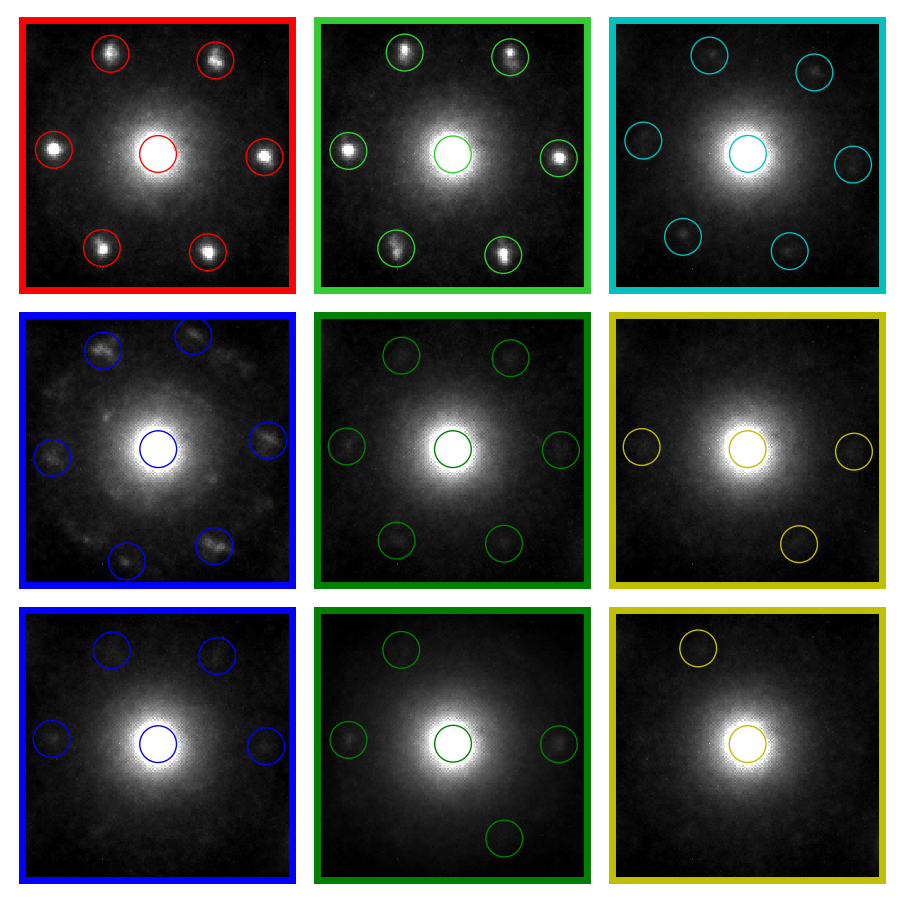

In [20]:
# Test hyperparameters on a few probe positions
# Visualize the diffraction patterns and the located disk positions

rxs = 47,47,85,71,44,43,42,56,40
rys = 75,74,45,77,72,71,70,6,68
colors=['r','limegreen','c','b','g','y','b','g','y']


# Hyperparameters
detect_params = {
    'corrPower': 1.0,
    'sigma': 4,
    'edgeBoundary': 8,
    'minRelativeIntensity': 0.003,
    'minAbsoluteIntensity': 0.2,
    'minPeakSpacing': 40,
    'subpixel' : 'poly',
#     'subpixel' : 'multicorr',
    'upsample_factor': 8,
    'maxNumPeaks': 1000,
     'CUDA': True,
}

disks_selected = dataset.find_Bragg_disks(
    data = (rxs, rys),
    template = probe_kernel,
    **detect_params,
)

py4DSTEM.visualize.show_image_grid(
    get_ar = lambda i:dataset.data[rxs[i],rys[i],:,:],
    H=3, 
    W=3,
    axsize=(3,3),
    get_bordercolor = lambda i:colors[i],
    get_x = lambda i: disks_selected[i].data['qx'],
    get_y = lambda i: disks_selected[i].data['qy'],
    get_pointcolors = lambda i: colors[i],
    open_circles = True,
    scale = 700,
)

In [21]:
data_selected = np.zeros((len(rxs), dataset.Q_Ny, dataset.Q_Nx))
for it in range(len(rxs)):
    data_selected[it,:,:] = dataset.data[rxs[it],rys[it],:,:]

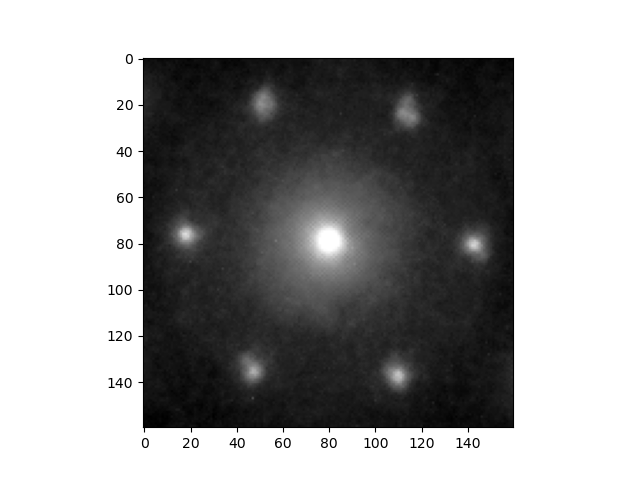

In [22]:
plt.figure()
plt.imshow(data_selected[0,:,:], cmap = 'Greys_r', norm=matplotlib.colors.LogNorm())

In [23]:
# Find Bragg peaks for all probe positions
bragg_peaks = dataset.find_Bragg_disks(
    template = probe_kernel,
    **detect_params,
)

Using 2 batches of 7780 patterns each...


Finding Bragg disks in batches: 100%|█████████████████████████████████████████████████| 2/2 [00:12<00:00,  6.41s/batch]

Analyzed 12769 diffraction patterns in 0.0h 0.0m 12.82s
(avg. speed 995.8058 patterns per second)


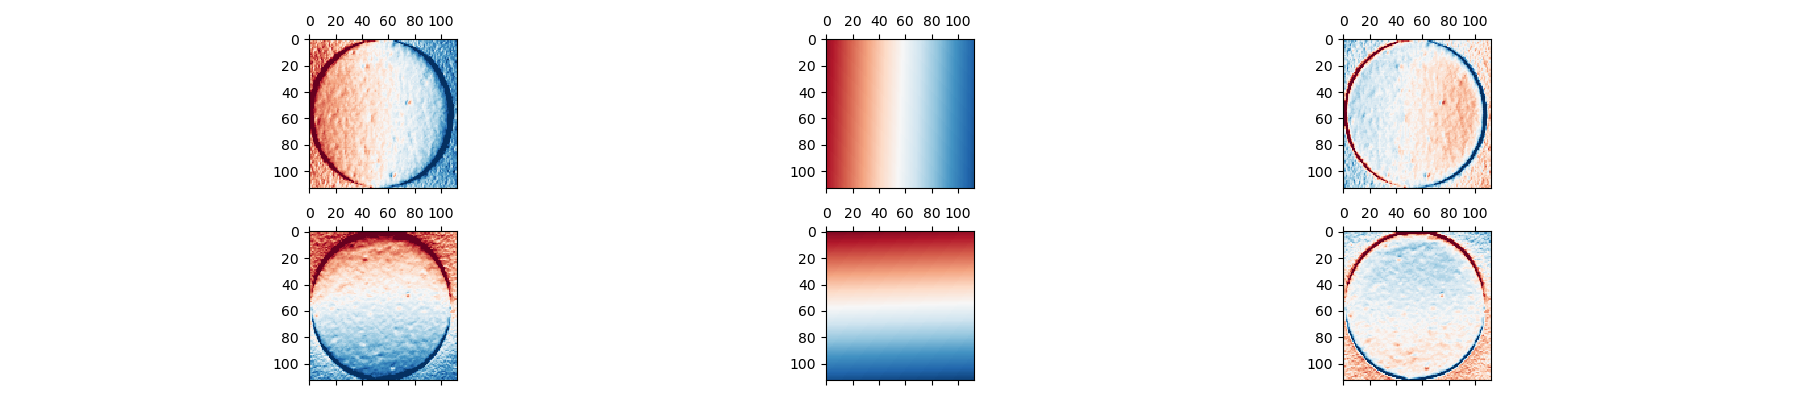

In [24]:
# Compute the origin position for all probe positions.
# This algorithm works by searching for peak pairs (Friedel symmetry) and finding the mean position of these pairs.

qxy_origins = bragg_peaks.measure_origin(
    mode = 'no_beamstop',
)

# Fit a plane to the origins
qx0_fit,qy0_fit,qx0_residuals,qy0_residuals = bragg_peaks.fit_origin(
    plot_range=.5
)

In [25]:
# apply the calibration
bragg_peaks.calibration.set_origin((qx0_fit, qy0_fit))
bragg_peaks.calibrate()

# Calculate BVM from centered data
bragg_vector_map_centered = bragg_peaks.get_bvm()

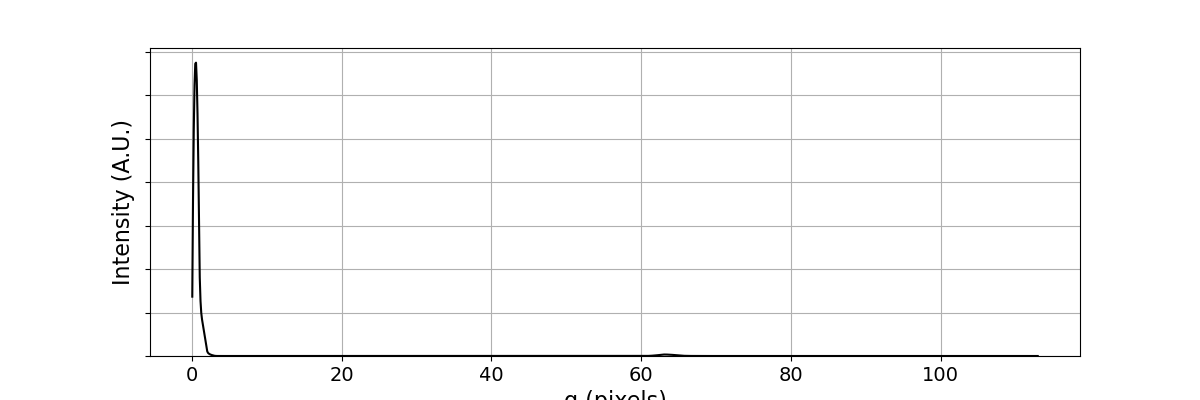

In [26]:
# Calculate and plot the radial integral.
# Note that for a 2D material, the center beam is orders of magnitude higher than the diffracted beam.
# Thus we need to specify a maximum y value for the plot.
# We also scale the plotted intensity by q to better show the higher angle peaks.
ymax = 16000

q, intensity_radial = py4DSTEM.process.utils.radial_integral(
    bragg_vector_map_centered,
)

py4DSTEM.visualize.show_qprofile(
    q = q,
    intensity = intensity_radial * q,
    
) # ymax = ymax

In [27]:
# Load the MoS2 crystal file
crystal_MoS2 = py4DSTEM.process.diffraction.Crystal.from_CIF(file_cif_MoS2)
crystal_C60 = py4DSTEM.process.diffraction.Crystal.from_CIF(file_cif_C60)

C:\ProgramData\Miniconda3\envs\py4dstem-aiml-e\lib\site-packages\pymatgen\io\cif.py:1164: UserWarning: Issues encountered while parsing CIF: Some fractional co-ordinates rounded to ideal values to avoid issues with finite precision.
  warnings.warn("Issues encountered while parsing CIF: %s" % "\n".join(self.warnings))


In [28]:
# Calculate structure factors
k_max = 1.4

crystal_MoS2.calculate_structure_factors(k_max,)
crystal_C60.calculate_structure_factors(k_max,)

In [29]:
unit_cell = np.array([[crystal_C60.cell[0], 0. , 0.], 
          [0., crystal_C60.cell[1] , 0.],
          [0., 0. , crystal_C60.cell[2]]])
Mm = np.linalg.inv(unit_cell)

In [30]:
zone = np.array([1, 1, 1]) # cubic C60
#zone = np.array([0, 0, 1]) 
#gx   = np.array([0, 1, -1]) # cubic C60
#gx   = np.array([1, 0, 0])
gz = np.dot(Mm,zone)
max_hkl = 8

for it in range(crystal_C60.g_vec_all.shape[1]):
    gx = crystal_C60.g_vec_all[:,it]
    gx = np.dot(Mm,gx)
    val0 = np.abs(np.dot(gx,gz))
    if ((val0 < 1e-6) & (np.abs(crystal_C60.hkl[0,it]) <= max_hkl) & (np.abs(crystal_C60.hkl[1,it]) <= max_hkl) & (np.abs(crystal_C60.hkl[2,it]) <= max_hkl)):
        print(str(crystal_C60.hkl[:,it]) + ' - ' + str("{:.3f}".format(crystal_C60.g_vec_leng[it]))  + ' - ' + str("{:.2e}".format(val0)))
    

[-8.  0.  8.] - 0.793 - 4.34e-19
[-8.  2.  6.] - 0.715 - 8.67e-19
[-8.  4.  4.] - 0.687 - 4.34e-19
[-8.  6.  2.] - 0.715 - 3.25e-19
[-8.  8.  0.] - 0.793 - 0.00e+00
[-6. -2.  8.] - 0.715 - 8.67e-19
[-6.  0.  6.] - 0.595 - 8.67e-19
[-6.  2.  4.] - 0.525 - 6.51e-19
[-6.  4.  2.] - 0.525 - 3.25e-19
[-6.  6.  0.] - 0.595 - 0.00e+00
[-6.  8. -2.] - 0.715 - 1.08e-19
[-4. -4.  8.] - 0.687 - 4.34e-19
[-4. -2.  6.] - 0.525 - 8.67e-19
[-4.  0.  4.] - 0.397 - 2.17e-19
[-4.  2.  2.] - 0.344 - 2.17e-19
[-4.  4.  0.] - 0.397 - 0.00e+00
[-4.  6. -2.] - 0.525 - 3.25e-19
[-4.  8. -4.] - 0.687 - 2.17e-19
[-2. -6.  8.] - 0.715 - 4.34e-19
[-2. -4.  6.] - 0.525 - 4.34e-19
[-2. -2.  4.] - 0.344 - 2.17e-19
[-2.  0.  2.] - 0.198 - 1.08e-19
[-2.  2.  0.] - 0.198 - 0.00e+00
[-2.  4. -2.] - 0.344 - 1.08e-19
[-2.  6. -4.] - 0.525 - 4.34e-19
[-2.  8. -6.] - 0.715 - 4.34e-19
[ 0. -8.  8.] - 0.793 - 4.34e-19
[ 0. -6.  6.] - 0.595 - 8.67e-19
[ 0. -4.  4.] - 0.397 - 2.17e-19
[ 0. -2.  2.] - 0.198 - 1.08e-19
[0. 0. 0.]

(0.0, 1.0)

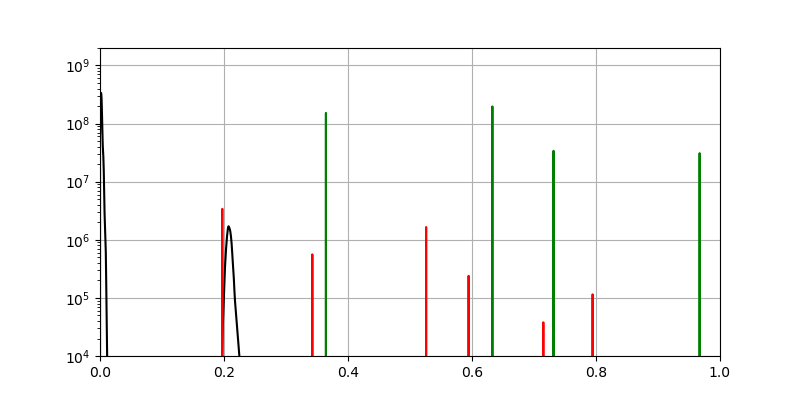

In [31]:
# Test different pixel sizes, and overlay the structure factors onto the experimental data.
# Note that we will use our knowledge that the MoS2 has an [0001] zone axis.

#camz_stage = 0.00 mm - Camera length = 20.56 mm - EHT = 20.00 kV - calibration factor = 0.033180 1/nm

#inv_Ang_per_pixel = 0.0192
binning_factor = 1
#inv_Ang_per_pixel = (0.033180*binning_factor*(1-0.008))/10.
inv_Ang_per_pixel = (0.033180*binning_factor*(1-0.008))*(3.6437/3.6538)/10. #-0.008

# inv_Ang_per_pixel from MoS2 part, due to overlapping Moiré peaks which mask the actual position of the diffraction peak


C60_zone = np.array([1,1,1])

q_SF = np.linspace(0,k_max,512)
I_SF_MoS2 = np.zeros_like(q_SF)
I_SF_C60 = np.zeros_like(q_SF)
for a0 in range(crystal_MoS2.g_vec_leng.shape[0]):
    if np.abs(crystal_MoS2.g_vec_all[2,a0]) < 0.01:
        idx = np.argmin(np.abs(q_SF-crystal_MoS2.g_vec_leng[a0]))
        I_SF_MoS2[idx] += crystal_MoS2.struct_factors_int[a0]
I_SF_MoS2 /= np.max(I_SF_MoS2)

#for a0 in range(crystal_C60.g_vec_leng.shape[0]):
#    if np.abs(crystal_C60.g_vec_all[2,a0]) < 0.01:
#        idx = np.argmin(np.abs(q_SF-crystal_C60.g_vec_leng[a0]))
#        I_SF_C60[idx] += crystal_C60.struct_factors_int[a0]
#I_SF_C60 /= np.max(I_SF_C60)

max_hkl = 8

for a0 in range(crystal_C60.g_vec_leng.shape[0]):
    gx = np.dot(Mm,crystal_C60.g_vec_all[:,a0])
    val0 = np.abs(np.dot(gx,gz))
    if ((val0 < 1e-6) & (np.abs(crystal_C60.hkl[0,a0]) <= max_hkl) & (np.abs(crystal_C60.hkl[1,a0]) <= max_hkl) & (np.abs(crystal_C60.hkl[2,a0]) <= max_hkl)):
        idx = np.argmin(np.abs(q_SF-crystal_C60.g_vec_leng[a0]))
        I_SF_C60[idx] += crystal_C60.struct_factors_int[a0]
I_SF_C60 /= np.max(I_SF_C60)

fig, ax = plt.subplots(1,1,figsize = (8,4))
ax.plot(q*inv_Ang_per_pixel,intensity_radial*(q),c='black')  
ax.set_yscale("log")
ax.set_ylim(10**4, 2*10**9)
ax.plot(q_SF,I_SF_C60*ymax*1000,c='r')
ax.plot(q_SF,I_SF_MoS2*ymax*20000,c='g')
ax.grid('on')
#ax.set_xlim([0.5, 0.8])
ax.set_xlim([0, 1.])

In [32]:
# Apply pixel size calibration
bragg_peaks.calibration.set_Q_pixel_size(inv_Ang_per_pixel)
bragg_peaks.calibration.set_Q_pixel_units('A^-1')
bragg_peaks.calibrate()

In [33]:
# Create an orientation plan for [0001] MoS2
crystal_MoS2.orientation_plan(
    angle_step_zone_axis = 1.,
    angle_step_in_plane = 3.,
    zone_axis_range = 'fiber',
    fiber_axis = [0,0,1],
    fiber_angles = [8,60],
    #angle_coarse_zone_axis (float): Coarse step size for zone axis search [degrees]. Setting to None uses the same value as angle_step_zone_axis.
    #angle_refine_range (float): Range of angles to use for zone axis refinement. Setting to None uses same value as angle_coarse_zone_axis.
    angle_refine_range = 0.05,
    CUDA=True,
)

crystal_C60.orientation_plan(
    angle_step_zone_axis = 1.,
    angle_step_in_plane = 3.,
    zone_axis_range = 'fiber',
    fiber_axis = [1,1,1],
    #fiber_axis = [0,0,1],
    #fiber_angles = [0,30],
    fiber_angles = [0,60],
    #angle_coarse_zone_axis (float): Coarse step size for zone axis search [degrees]. Setting to None uses the same value as angle_step_zone_axis.
    #angle_refine_range (float): Range of angles to use for zone axis refinement. Setting to None uses same value as angle_coarse_zone_axis.
    angle_refine_range = 0.05,
    #tol_distance = 0.02,
    CUDA=True,
)

Orientation plan: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 83.27 zone axes/s]


Best fit lattice directions: z axis = ([0.577 0.577 0.577]), x axis = ([ 0.816 -0.38  -0.435]), with corr value = 0.583


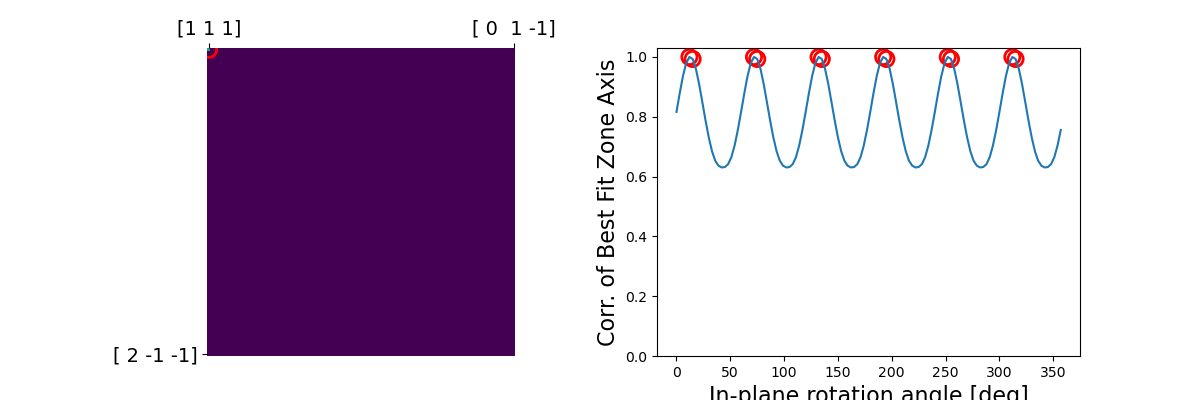

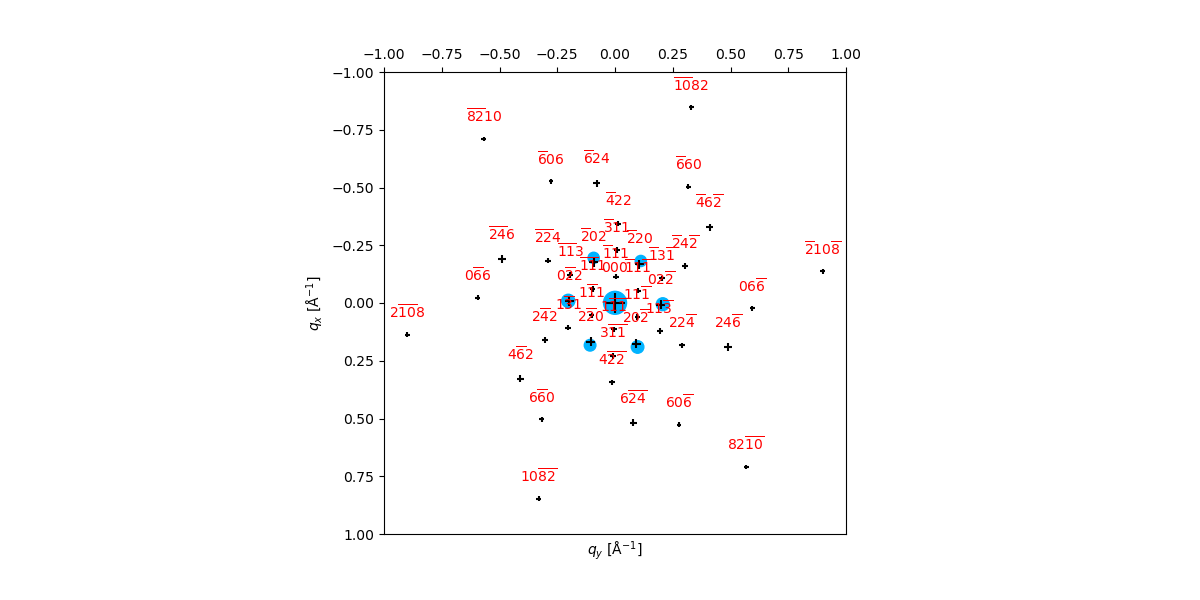

In [34]:
# Test matching on some probe positions
# xind, yind = 64,64
rxy_index  = 0
xind, yind = rxs[rxy_index],rys[rxy_index]

#rxs = 47,47,85,71,44,43,42,56,40
#rys = 75,74,45,77,72,71,70,6,68

#orientation  = crystal_MoS2.match_single_pattern(
orientation  = crystal_C60.match_single_pattern(
    bragg_peaks.vectors[xind,yind],
    plot_corr = True,
#     plot_polar = False,
    verbose = True,
)

sigma_compare = 0.03
#range_plot = np.array([k_max+0.1,k_max+0.1])
range_plot = np.array([1.,1.])

#bragg_peaks_fit = crystal_MoS2.generate_diffraction_pattern(
bragg_peaks_fit = crystal_C60.generate_diffraction_pattern(
    orientation,
    ind_orientation=0,
    sigma_excitation_error=sigma_compare)


# plot comparisons
py4DSTEM.process.diffraction.plot_diffraction_pattern(
    bragg_peaks_fit,
    bragg_peaks_compare=bragg_peaks.vectors[xind,yind],
    scale_markers=1000,
    scale_markers_compare=1e1,
    plot_range_kx_ky=range_plot,
    min_marker_size=1,
)

In [35]:
# Fit orientation to all probe positions
orientation_map = crystal_C60.match_orientations(
    bragg_peaks.vectors,
    min_number_peaks=7,
)

Matching Orientations: 100%|███████████████████████████████████████████| 12769/12769 [00:06<00:00, 2022.19 PointList/s]


In [36]:
strain_map = crystal_C60.calculate_strain(
    bragg_peaks.vectors,
    orientation_map,
    rotation_range=2.*np.pi/6.,
#     corr_kernel_size=0.02,
)

Calculating strains: 100%|█████████████████████████████████████████████| 12769/12769 [00:02<00:00, 5069.44 PointList/s]


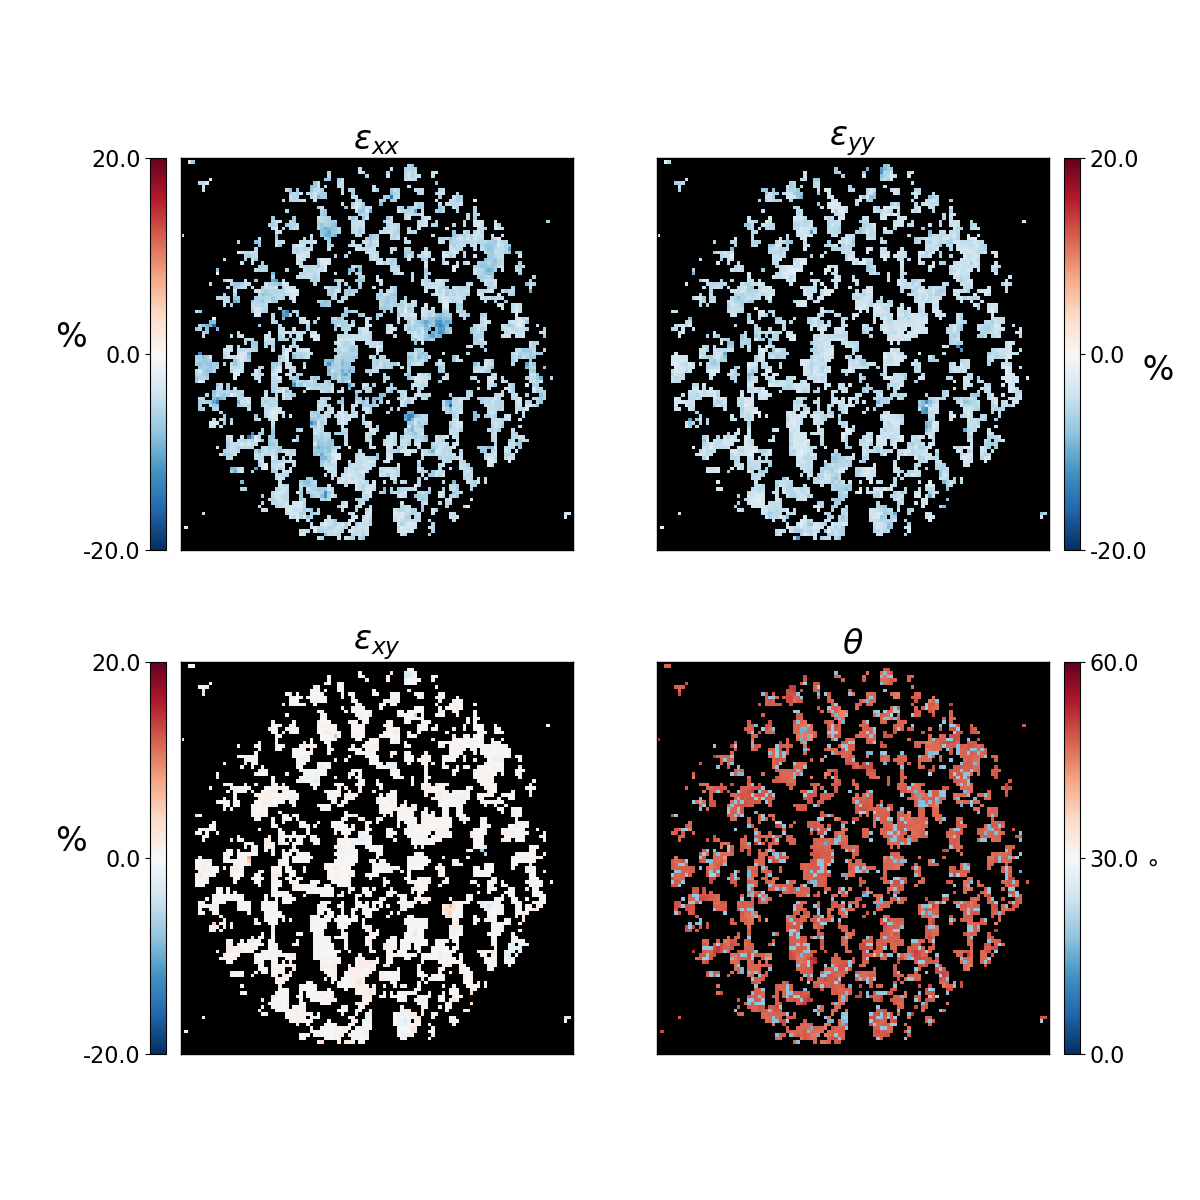

In [37]:
# plot the 4 components of the strain tensor
fig,ax = py4DSTEM.visualize.show_strain(
    strain_map,
    vrange_exx=[-20., 20.],
    vrange_theta=[0., 60.],
    ticknumber=3,
    axes_plots=(),
    bkgrd=False,
    figsize=(12,12),
    #cmap='hsv',
    returnfig=True,

)

In [38]:
# export results
#https://github.com/py4dstem/py4DSTEM/blob/dev/py4DSTEM/visualize/vis_special.py
strain_map_e_xx = np.ma.array(strain_map.get_slice('e_xx').data,mask=strain_map.get_slice('mask').data==False)
strain_map_e_yy = np.ma.array(strain_map.get_slice('e_yy').data,mask=strain_map.get_slice('mask').data==False)
strain_map_e_xy = np.ma.array(strain_map.get_slice('e_xy').data,mask=strain_map.get_slice('mask').data==False)
strain_map_theta = np.ma.array(strain_map.get_slice('theta').data,mask=strain_map.get_slice('mask').data==False)


disks_selected_qx = []
for it in range(len(disks_selected)):
    disks_selected_qx.append(disks_selected[it]['qx'])
disks_selected_qy = []
for it in range(len(disks_selected)):
    disks_selected_qy.append(disks_selected[it]['qy'])

In [39]:
np.unravel_index(np.argmin(strain_map_theta),strain_map_theta.shape)

(71, 77)

In [40]:
np.unravel_index(np.argmax(strain_map_theta),strain_map_theta.shape)

(85, 45)

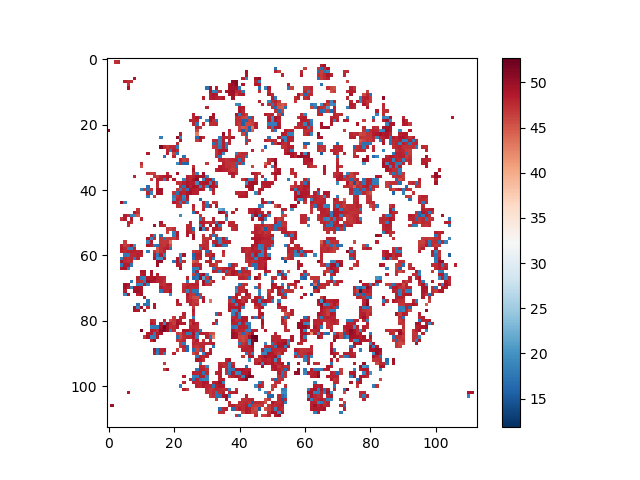

In [41]:
# There seems to be a bug in finding the angle: some pixels are 30 deg of from the actual rotation 
# see neighbouring diffraction patterns e.g. in cell with "# Test hyperparameters on a few probe positions"
# e.g. (rxs = 47, rys = 75) and (rxs = 47, rys = 74) are off by 30 deg, but they are similar 
# the manual matching get's it correct (cell with "# Test matching on some probe positions")
# -> compensate pixels with 30 deg error in plotting notebook
plt.figure()
#plt.imshow(strain_map_e_xx, cmap = 'RdBu_r', vmin = -0.2, vmax = 0.2)
plt.imshow((strain_map_theta*180./np.pi), cmap = 'RdBu_r')
plt.colorbar()

In [42]:
file_cif = file_cif_C60

In [46]:
%%time
#write results and parameters to disk
parameter_file_name = datetime.now().strftime("%Y%m%d_%H%M%S")
data = dict([(i, globals()[i]) for i in ('data_folder','data_name','data_path',
                                         'file_cif',
                                         'strain_map_e_xx', 'strain_map_e_yy',
                                         'strain_map_e_xy','strain_map_theta',
                                         #'images_orientation',
                                         'disks_selected_qx', 'disks_selected_qy', 'data_selected', 'rxs', 'rys'
                                         )])
with open(data_folder + r'//' + parameter_file_name + data_name.split('.')[0][1:] + 'strain_orientation_map_C60.pkl', 'wb') as f:
    pickle.dump(data, f)

CPU times: total: 0 ns
Wall time: 8 ms


In [43]:
data_folder

'..\\data\\Figure 4'